## Install & Import Libraries

In [ ]:
!pip install tensorflow
!pip install opencv-python

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil
import os
import matplotlib.pyplot as plt
import cv2
import random
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

## Create Dataframe

In [5]:
import os
import pandas as pd

directory = 'pneumonia-chest-x-ray-dataset'
file_paths = []
data = pd.DataFrame(columns=['paths', 'case', 'split'])

for root, directories, files in os.walk(directory):
    for filename in files:
        filepath = os.path.join(root, filename)
        if filepath.endswith(".jpeg"):
            path = os.path.split(os.path.split(filepath)[0])
            case = path[1]
            split = os.path.split(path[0])[1]
            data = data.append({'paths': filepath, 'case': case, 'split': split}, ignore_index=True)

train_df = data[data['split'] == 'train'].reset_index(drop=True)
test_df = data[data['split'] == 'test'].reset_index(drop=True)
val_df = data[data['split'] == 'val'].reset_index(drop=True)


## Data Visualization

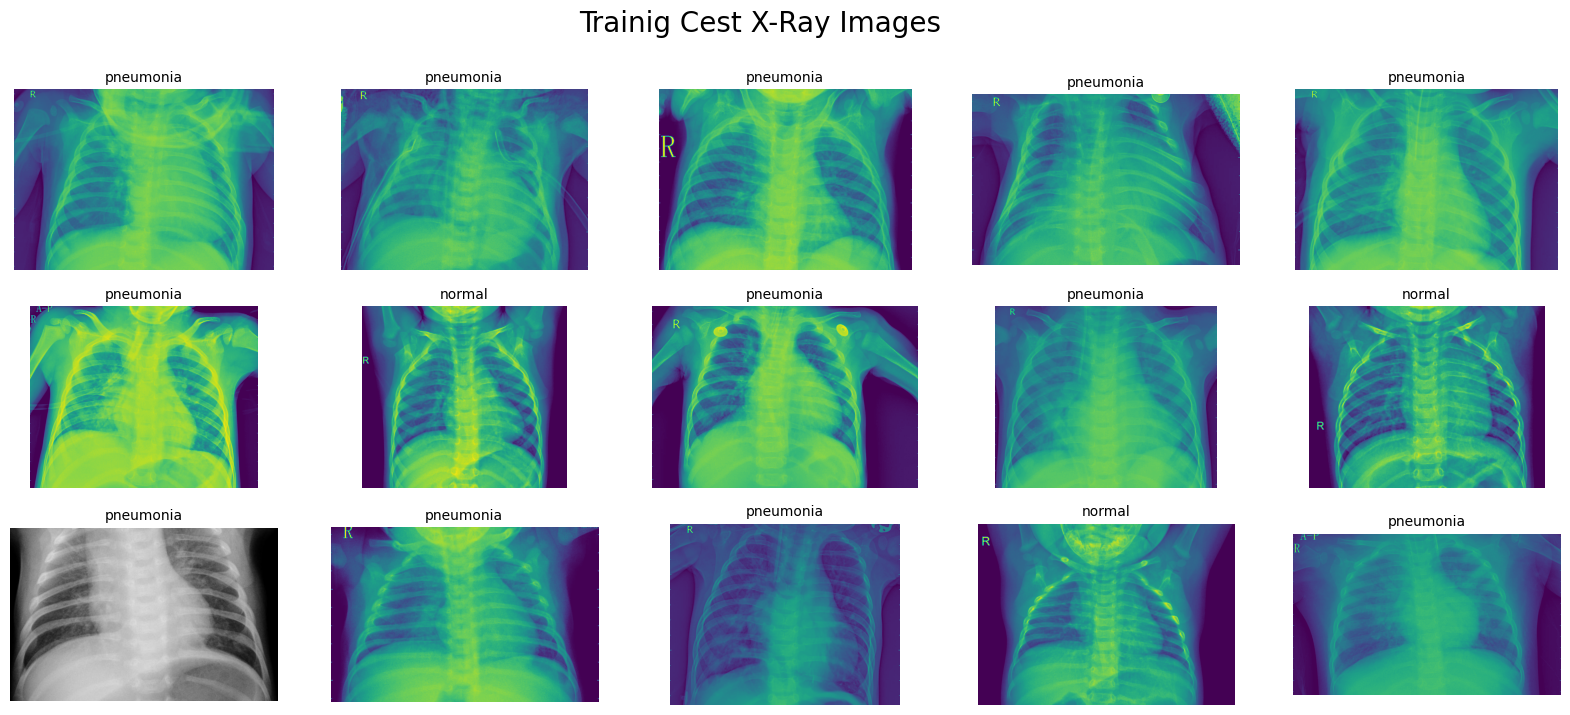

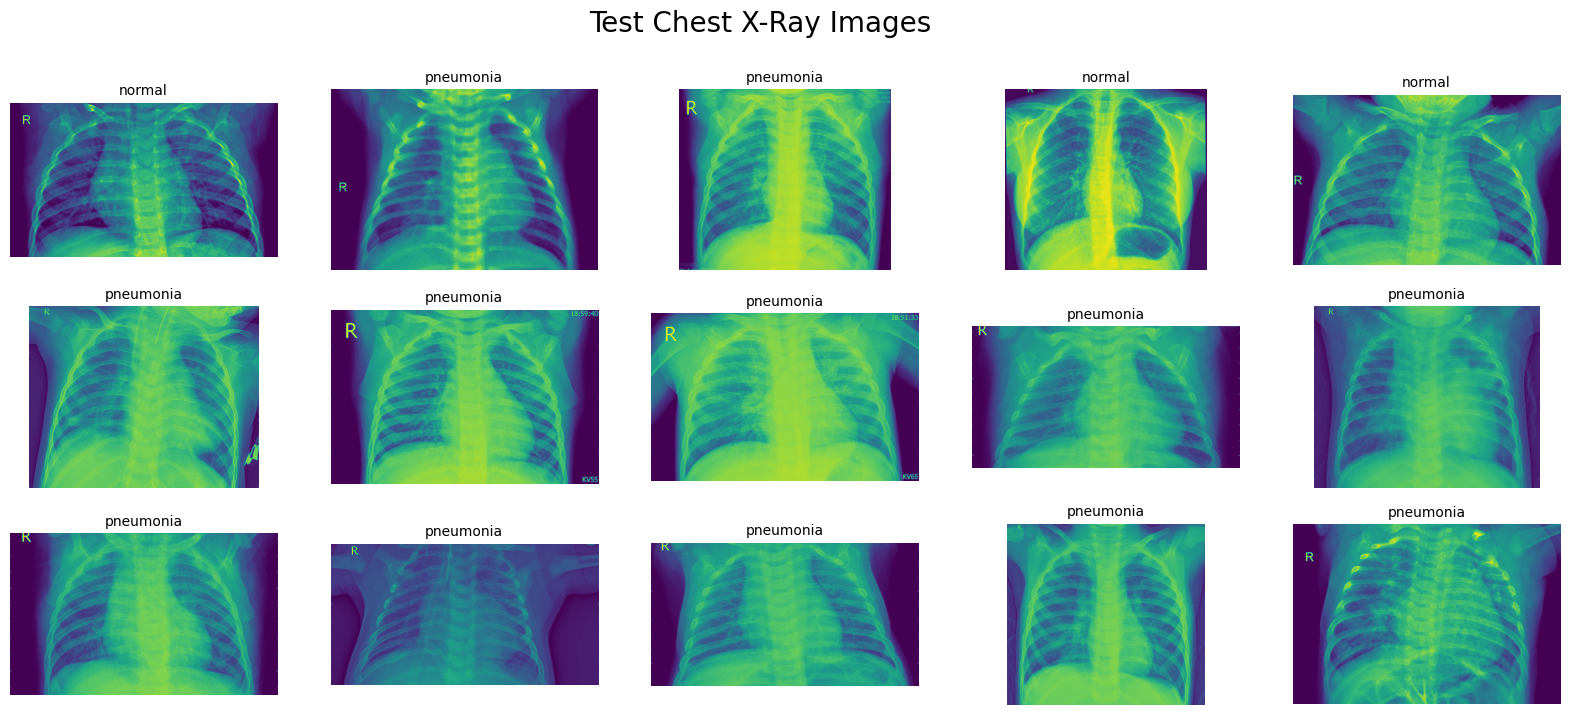

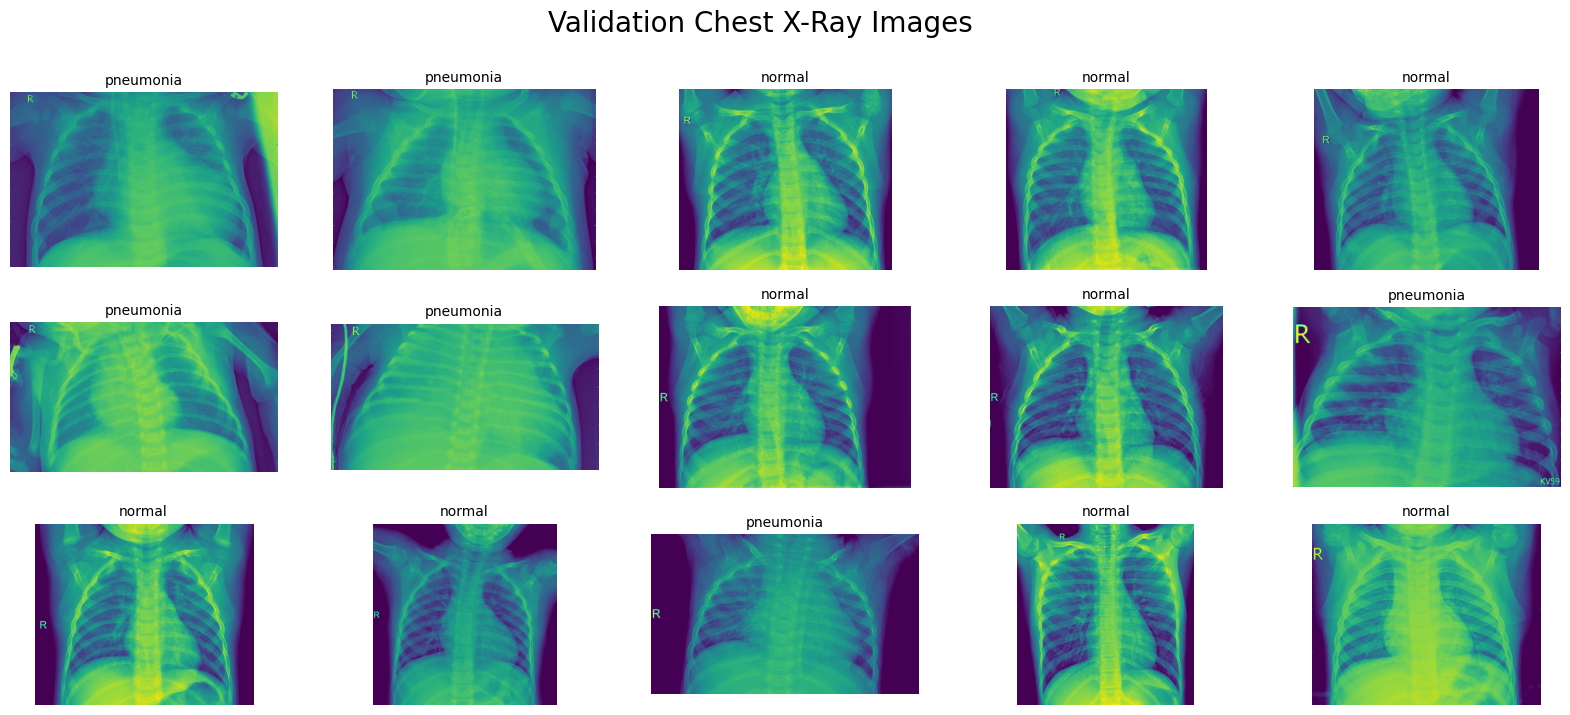

In [6]:
def image_viewer(dataset, index, ax):
    image_path =  dataset['paths'][index]
    image      =  Image.open(image_path)
    ax.imshow(image)
    
def plot_some_images(dataset, title):
    fig, axs = plt.subplots(nrows = 3,ncols = 5,figsize=(20,8))
    for ind, ax in enumerate(axs.flat):
            index = random.randrange(len(dataset))
            image_viewer(dataset, index, ax)
            ax.set_title(dataset['case'][index], fontsize = 10)
            ax.axis('off')
            fig.suptitle(title, fontsize = 20)
    plt.show()
    
plot_some_images(train_df, 'Trainig Cest X-Ray Images')
plot_some_images(test_df, 'Test Chest X-Ray Images')
plot_some_images(val_df, 'Validation Chest X-Ray Images')

In [8]:
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes= np.unique(train_df['case']),
                                     y= train_df['case'])

classes = (np.unique(train_df['case']))

class_weights = dict(zip(range(43), class_weights))

## Model Initialization

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rescale=1.0 / 255,  # Rescale pixel values to [0, 1]
    shear_range=0.1,  # Shear transformation by up to 10% - Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.1,  # Zoom in/out by up to 10%
    horizontal_flip=True,  # Horizontal flip
    brightness_range=[0.9, 1.1],  # Random brightness adjustments
)
val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
) 
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='paths',
    y_col= 'case',
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode="binary",
    batch_size=64,
    shuffle=True,
    seed=210,
)
val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='paths',
    y_col= 'case',
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=64,
    class_mode="binary",
    shuffle=True,
    seed=210,
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='paths',
    y_col= 'case',
    target_size=(256, 256),
    class_mode="binary",
    color_mode='grayscale',
    batch_size=64,
    shuffle=False
)

Found 4334 validated image filenames belonging to 2 classes.
Found 898 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [5]:
trans_arc = tf.keras.applications.EfficientNetB0(weights = "imagenet", include_top = False,
                         input_shape=(256, 256,3), pooling='max')
for l in trans_arc.layers:
    l.trainable = False
inputs = trans_arc.input
flatten = trans_arc.output

x = tf.keras.layers.Dense(256, activation='relu')(flatten)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

16705208/16705208 [==============================] - 3s 0us/step


In [7]:
loss = [tf.keras.losses.binary_crossentropy]

initial_learning_rate = 0.005

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=80,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(
    learning_rate= lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
)
metrics= ['accuracy']

model.compile(
    optimizer=optimizer,
    loss= loss,
    metrics=metrics
    )

In [10]:
history = model.fit(
      train_images,
      validation_data=val_images,
      verbose = True,
      epochs=20,
      class_weight = class_weights,
      callbacks=[
          tf.keras.callbacks.LearningRateScheduler(lr_schedule),
          tf.keras.callbacks.EarlyStopping(
              monitor='val_loss',
              patience=5,
              restore_best_weights=True),
      ]
  )

model.save('efficientnet_model.keras')

Epoch 1/20
82/82 [==============================] - 268s 3s/step - loss: 0.2012 - accuracy: 0.9202 - val_loss: 0.6337 - val_accuracy: 0.7500 - lr: 0.0050
Epoch 2/20
82/82 [==============================] - 249s 3s/step - loss: 0.1209 - accuracy: 0.9509 - val_loss: 0.0915 - val_accuracy: 0.9375 - lr: 0.0045
Epoch 3/20
82/82 [==============================] - 250s 3s/step - loss: 0.0868 - accuracy: 0.9663 - val_loss: 0.5687 - val_accuracy: 0.8125 - lr: 0.0040
Epoch 4/20
82/82 [==============================] - 254s 3s/step - loss: 0.0847 - accuracy: 0.9657 - val_loss: 0.5099 - val_accuracy: 0.8125 - lr: 0.0036
Epoch 5/20
82/82 [==============================] - 260s 3s/step - loss: 0.0726 - accuracy: 0.9722 - val_loss: 0.3688 - val_accuracy: 0.8750 - lr: 0.0033
Epoch 6/20
82/82 [==============================] - 266s 3s/step - loss: 0.0617 - accuracy: 0.9755 - val_loss: 0.1311 - val_accuracy: 0.9375 - lr: 0.0030
Epoch 7/20
82/82 [==============================] - 257s 3s/step - loss: 0.0

C:\Users\Sarubi\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


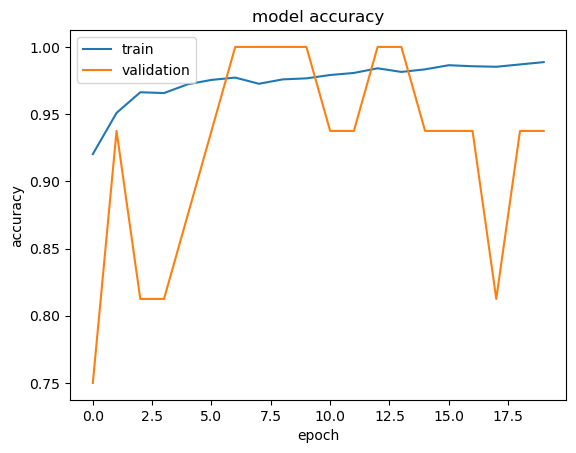

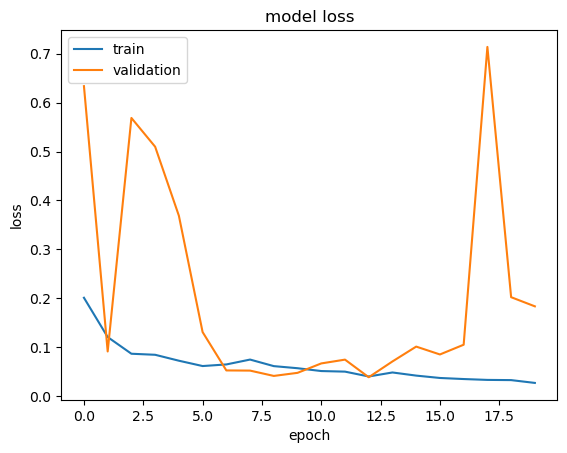

In [12]:
print(history.history.keys())

# accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Evaluation

In [2]:
from tensorflow import keras

# Load the model
loaded_model = keras.models.load_model('efficientnet_model.keras')
model=loaded_model

    Test Loss: 0.37754
Test Accuracy: 89.26%
10/10 [==============================] - 30s 3s/step


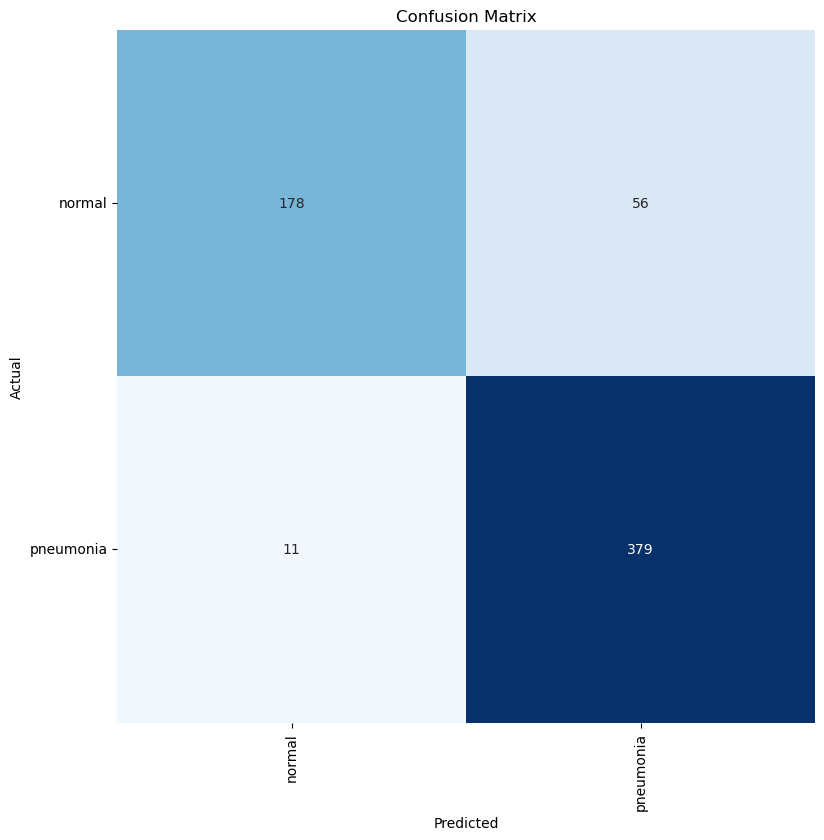

Classification Report:
----------------------
               precision    recall  f1-score   support

      normal       0.94      0.76      0.84       234
   pneumonia       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



In [12]:
def plot_model_evaluation(model, test_data, n_classes, target_labels):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]

    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))

    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=target_labels)

    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(n_classes) + 0.5, labels=list(test_data.class_indices.keys()), rotation=90)
    plt.yticks(ticks=np.arange(n_classes) + 0.5, labels=list(test_data.class_indices.keys()), rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)
    
plot_model_evaluation(model, test_images, 2, test_df['case'].unique())
